# Bayes Factor

The Bayes factor compares the evidence across **one family of models to that of another family**, averaged over the **parameter uncertainty** within each family.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide24.png)

# Key Formula

The Bayes factor quantifies the relative evidence for two competing model families $\text{M}_1$ and $\text{M}_2$ given observed data $\text{D}$. It compares the marginal likelihoods by integrating over all possible parameter values weighted by their prior distributions:

$$
\text{BF}_{12} = \frac{P(\text{D}\mid \text{M}_1)}{P(\text{D}\mid \text{M}_2)} = \frac{\int P(\text{D}\mid \theta_{1}, \text{M}_{1}) \, P(\theta_{1}\mid \text{M}_{1}) \, d\theta_{1}}{\int P(\text{D}\mid \theta_{2}, \text{M}_{2}) \, P(\theta_{2}\mid \text{M}_{2}) \, d\theta_{2}}
$$

where:
- $P(\text{D}|\theta_i, \text{M}_i)$ is the likelihood of data given parameters $\theta_i$ under model family $\text{M}_i$
- $P(\theta_i|\text{M}_i)$ is the prior distribution of parameters under model family $\text{M}_i$
- The integrals compute the marginal likelihood (evidence) for each model family

# Technical Details

## Bayes Factor vs. Likelihood Ratio

The Bayes factor compares model families by integrating over all parameter values weighted by priors, while a likelihood ratio (introduced in [Lecture: likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html)) compares specific models at specific parameter values. When comparing nested models at their maximum likelihood estimates, this becomes the likelihood ratio test with well-defined asymptotic distribution (Wilks' theorem). This reflects the fundamental distinction: **frequentists treat parameters as fixed unknowns to estimate; Bayesians treat parameters as random variables with probability distributions**.

## Prior Sensitivity
Bayes factors depend on prior specifications. When priors are vague or improper, the Bayes factor may not be well-defined. Sensitivity analysis examining how results change under different reasonable priors is recommended.

## Model Complexity Penalty
An advantage of Bayes factors is that they automatically penalize model complexity by averaging over parameter uncertainty, guarding against overfitting. A complex model must explain the data well across much of its parameter space to achieve high marginal likelihood.

## Interpretation Guidelines

Following [Kass and Raftery (1995)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572), Bayes factors are typically interpreted as:

|  $\text{BF}_{12}$ | Strength of evidence (for $\text{M}_1$ over $\text{M}_2$) |
|------------------|--------------------------------------------|
|1 to 3.2         | Not worth more than a bare mention |
|3.2 to 10        | Substantial |
|10 to 100        | Strong |
|> 100            | Decisive |

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html)
- [Bayesian and frequentist](https://statfungen.github.io/statgen-primer/Bayesian_frequentist.html)
- [random effect](https://statfungen.github.io/statgen-primer/random_effect.html)

# Example

We will use the same genetic example from the [Lecture: likelihood](https://statfungen.github.io/statgen-primer/likelihood.html), and recall the concepts of MLE as we did in Example 2 in [Lecture: maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html).

Now you're faced with a decision problem: Should you believe there's no genetic effect at all, or should you believe there's some kind of effect? But here's where it gets interesting - if you think there's an effect, how do you handle the uncertainty about exactly how big that effect might be?

This leads to two different approaches for comparing hypotheses:
- **Likelihood ratios**: Compare specific effect sizes (like "no effect" vs "exactly 0.5 units per allele", as we did in [Lecture: likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html))
- **Bayes factors**: Compare families of models

For Bayes factors, we'll compare these two model families:
- **Model Family 1**: No effect ($\beta = 0$, point mass)
- **Model Family 2**: Some effect ($\beta \sim N(0, 1)$, representing our uncertainty about the effect size). Here $\beta$ is a random effect

Let's see how these approaches work with the same data.

## Setup

In [1]:
# Clear the environment
rm(list = ls())
library(ggplot2)
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at a single variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

## Likelihood and Log-likelihood

In [2]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  # Calculate likelihood (product of normal densities)
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  # Calculate log-likelihood (sum of log normal densities)
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}


## Bayes Factor

Now let's compare two model families:

- **Model Family 1: "No Effect"**
  - This is actually just a **single model**: $\beta = 0$ exactly
  - It's a "point mass" prior - all probability is concentrated at b$\beta = 0$
  - There's no uncertainty about the parameter value within this family
  - We're saying: "The genetic variant has absolutely no effect"

- **Model Family 2: "Some Effect"**
  - This is a **family of infinitely many models**: beta can be any value from the normal distribution $N(0, 1)$
  - Different values of beta within this family have different probabilities based on the prior
  - We're saying: "We believe there's some effect, but we're uncertain about exactly how big it is"
  - Values around 0 are most plausible, but values like 0.5, 1.0, 0.9, etc. are also possible with lower probability


Now let's compare model families by integrating over parameter uncertainty:

In [3]:
# Define prior distributions for each model family
# Model Family 1: beta = 0 (point mass)
# Model Family 2: beta ~ Normal(0, 1)

prior_mean <- 0
prior_sd <- 1

# Function to calculate marginal likelihood for Model Family 2
marginal_likelihood <- function(X, Y, sd, prior_mean, prior_sd, 
                                     beta_range = c(-5, 5), n_points = 2000) {
  beta_grid <- seq(beta_range[1], beta_range[2], length.out = n_points)
  delta_beta <- diff(beta_grid)[1]
  
  log_integrand <- numeric(n_points)
  for (i in 1:n_points) {
    beta_i <- beta_grid[i]
    log_lik_i <- log_likelihood(beta_i, sd, X, Y)
    log_prior_i <- dnorm(beta_i, mean = prior_mean, sd = prior_sd, log = TRUE)
    log_integrand[i] <- log_lik_i + log_prior_i
  }
  
  # Log-sum-exp trick for numerical stability
  max_log <- max(log_integrand)
  log_marginal_lik <- max_log + log(sum(exp(log_integrand - max_log)) * delta_beta)
  
  return(exp(log_marginal_lik))
}

# Calculate marginal likelihoods

marginal_lik_model_family_1 <- likelihood(beta = 0, sd = true_sd, X = X, Y = Y)  # Point mass at beta = 0
marginal_lik_model_family_2 <- marginal_likelihood(X, Y, true_sd, prior_mean, prior_sd)

# Calculate Bayes Factor (BF_12 = Model 1 vs Model 2)
bf_12 <- marginal_lik_model_family_1 / marginal_lik_model_family_2

cat("Marginal Likelihood (Model Family 1, beta=0):", marginal_lik_model_family_1, "\n")
cat("Marginal Likelihood (Model Family 2, beta~N(0,1)):", marginal_lik_model_family_2, "\n")
cat("Bayes Factor (BF_12):", bf_12, "\n")

# Interpretation
if (bf_12 > 1) {
  cat("Interpretation: Evidence favors Model Family 1 (no effect)\n")
} else {
  cat("Interpretation: Evidence favors Model Family 2 (some effect exists)\n")
}

Marginal Likelihood (Model Family 1, beta=0): 0.00192103 
Marginal Likelihood (Model Family 2, beta~N(0,1)): 0.001008886 
Bayes Factor (BF_12): 1.90411 
Interpretation: Evidence favors Model Family 1 (no effect)


## Visualization

Let's visualize the results:


In [4]:
# Create a range of beta values for plotting
beta_range <- seq(-1.5, 1.5, length.out = 200)
likelihood_curve <- numeric(length(beta_range))

# Calculate likelihood for each beta value
for (i in 1:length(beta_range)) {
  likelihood_curve[i] <- likelihood(beta_range[i], true_sd, X, Y)
}

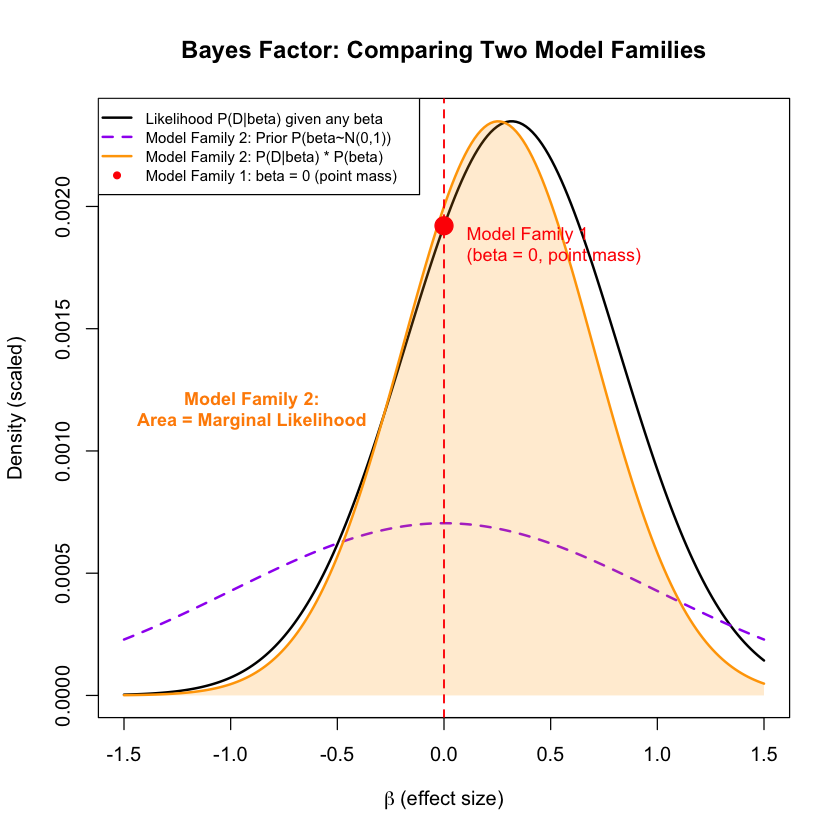

In [5]:
plot(beta_range, likelihood_curve, type = "l", lwd = 2, col = "black",
     xlab = expression(beta~"(effect size)"), 
     ylab = "Density (scaled)", 
     main = "Bayes Factor: Comparing Two Model Families")

# Model Family 2: Show the prior distribution for "some effect" model
prior_curve <- dnorm(beta_range, mean = prior_mean, sd = prior_sd)
prior_curve_scaled <- prior_curve * max(likelihood_curve) / max(prior_curve) * 0.3
lines(beta_range, prior_curve_scaled, col = "purple", lwd = 2, lty = 2)

# Model Family 2: Show the integrand (likelihood * prior)
integrand_curve <- likelihood_curve * prior_curve
integrand_scaled <- integrand_curve / max(integrand_curve) * max(likelihood_curve)
lines(beta_range, integrand_scaled, col = "orange", lwd = 2)

# Model Family 2: Shade the area under likelihood * prior to show integration
polygon(c(beta_range, rev(beta_range)), 
        c(integrand_scaled, rep(0, length(beta_range))),
        col = rgb(1, 0.65, 0, 0.2), border = NA)

# Model Family 1: Mark no effect model (point mass at beta = 0)
points(0, marginal_lik_model_family_1, col = "red", pch = 19, cex = 2)
abline(v = 0, col = "red", lty = 2, lwd = 1.5)

# Add text annotations
text(0.05, marginal_lik_model_family_1 * 0.95, 
     "Model Family 1\n(beta = 0, point mass)", col = "red", cex = 0.9, pos = 4)

text(-0.9, max(likelihood_curve) * 0.5, 
     "Model Family 2:\nArea = Marginal Likelihood", 
     col = "darkorange", cex = 0.9, font = 2)

# Updated legend with clear model family labels
legend("topleft", 
       c("Likelihood P(D|beta) given any beta", 
         "Model Family 2: Prior P(beta~N(0,1))", 
         "Model Family 2: P(D|beta) * P(beta)", 
         "Model Family 1: beta = 0 (point mass)"),
       col = c("black", "purple", "orange", "red"), 
       lty = c(1, 2, 1, NA), 
       pch = c(NA, NA, NA, 19), 
       lwd = c(2, 2, 2, NA),
       cex = 0.75,
       bg = "white")

**Exercise**: Here the Bayes factor between the two models is 1.90, which doesn't suggest very strong evidence. This is mainly because of the fact that there are only five samples in the data. Try to increase the number of samples and see how Bayes factor changes.